In [1]:
from nearest_neighbors import KNNClassifier
from cross_validation import knn_cross_val_score, kfold, accuracy
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import cv2
import time

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X = mnist.data.to_numpy() 
y = mnist.target.to_numpy()  

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(X_train.shape)  
print(y_train.shape)  
print(X_test.shape)  
print(y_test.shape) 


(60000, 784)
(60000,)
(10000, 784)
(10000,)


# 1. Сравнение алгоритмов

In [15]:
own = KNNClassifier(k = 5)
brute = KNNClassifier(k = 5, strategy="brute")
kd_tree = KNNClassifier(k = 5, strategy="kd_tree")
ball_tree = KNNClassifier(k = 5, strategy="ball_tree")

Выбираем признаки

In [18]:
ten = np.random.choice(784, 10, replace=False)
twelve = np.random.choice(784, 20, replace=False)
hundred = np.random.choice(784, 100, replace=False)

In [22]:
import time
own_times = []
brute_times = []
kd_times = []
ball_times = []
for nf in [ten,twelve,hundred]:
    own.fit(X_train[:,nf],y_train)
    s = time.time()
    own.find_kneighbors(X_test[:,nf])
    e = time.time()
    own_times.append(e - s)

    brute.fit(X_train[:,nf],y_train)
    s = time.time()
    brute.find_kneighbors(X_test[:,nf])
    e = time.time()
    brute_times.append(e - s)

    kd_tree.fit(X_train[:,nf],y_train)
    s = time.time()
    kd_tree.find_kneighbors(X_test[:,nf])
    e = time.time()
    kd_times.append(e - s)

    ball_tree.fit(X_train[:,nf],y_train)
    s = time.time()
    ball_tree.find_kneighbors(X_test[:,nf])
    e = time.time()
    ball_times.append(e - s)

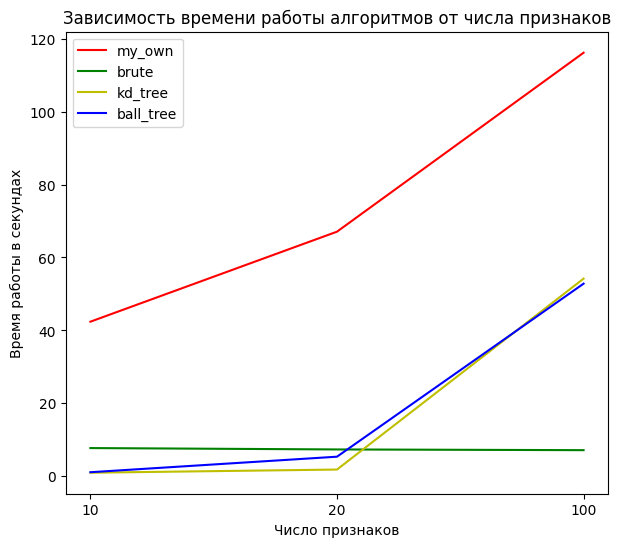

In [30]:
x = ["10","20", "100"]
plt.figure(figsize=(7,6))
plt.title("Зависимость времени работы алгоритмов от числа признаков")
plt.plot(x, own_times, color="r", label="my_own")
plt.plot(x, brute_times, color="g", label="brute")
plt.plot(x, kd_times, color="y", label="kd_tree")
plt.plot(x, ball_times, color="b", label = "ball_tree")
plt.xlabel("Число признаков")
plt.ylabel("Время работы в секундах")
plt.legend()
plt.show()

# 2. Кросс валидация

In [6]:
s = time.time()
euclidean = knn_cross_val_score(X_train, y_train,range(1,11),cv=kfold(60000, 3),weights=False, strategy="brute")
e_time = time.time() - s
s = time.time()
cosine = knn_cross_val_score(X_train, y_train,range(1,11),cv=kfold(60000, 3),weights=False, strategy="brute", metric="cosine")
c_time = time.time() - s

In [7]:
print(e_time,c_time)

48.133172273635864 50.4723539352417


In [53]:
e_means = [np.mean(x) for x in euclidean.values()]
c_means = [np.mean(x) for x in cosine.values()]

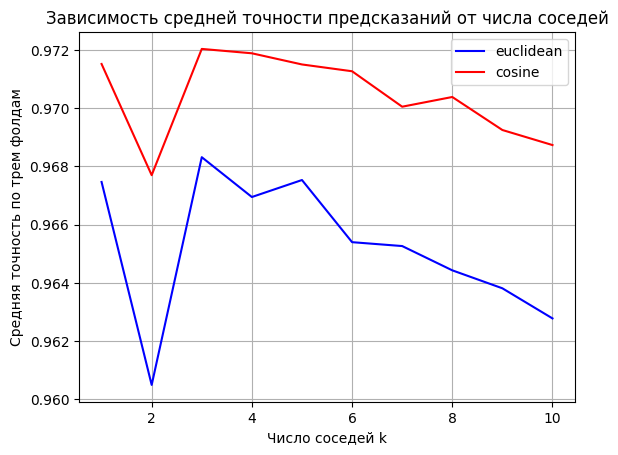

In [54]:
plt.plot(range(1,11), e_means, color="b", label="euclidean")
plt.plot(range(1,11), c_means, color="r", label="cosine")
plt.title("Зависимость средней точности предсказаний от числа соседей")
plt.grid()
plt.xlabel("Число соседей k")
plt.ylabel("Средняя точность по трем фолдам")
plt.legend()
plt.show()

# 3. Сравнение со взвешенным

In [8]:
nw = knn_cross_val_score(X_train, y_train,range(1,11),score="accuracy",cv=kfold(60000, 3),weights=False, strategy="brute",metric="cosine")
w = knn_cross_val_score(X_train, y_train,range(1,11),score="accuracy",cv=kfold(60000, 3),weights=True, strategy="brute",metric="cosine")

In [9]:
nw_means = [np.mean(x) for x in nw.values()]
w_means = [np.mean(x) for x in w.values()]

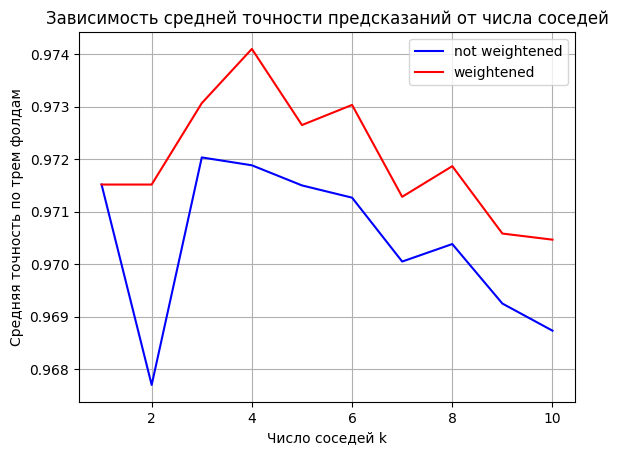

In [57]:
plt.plot(range(1,11), nw_means, color="b", label="not weightened")
plt.plot(range(1,11), w_means, color="r", label="weightened")
plt.title("Зависимость средней точности предсказаний от числа соседей")
plt.grid()
plt.xlabel("Число соседей k")
plt.ylabel("Средняя точность по трем фолдам")
plt.legend()
plt.show()

# 4. Лучшая модель

In [8]:
model = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(accuracy(y_test, pred))

0.9752


In [4]:
cros_val = knn_cross_val_score(X_train, y_train, [4], cv = kfold(X_train.shape[0],3), strategy="brute", metric="cosine", weights=True)

In [5]:
cros_val

{4: [0.97545, 0.9732, 0.97365]}

In [19]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, pred)

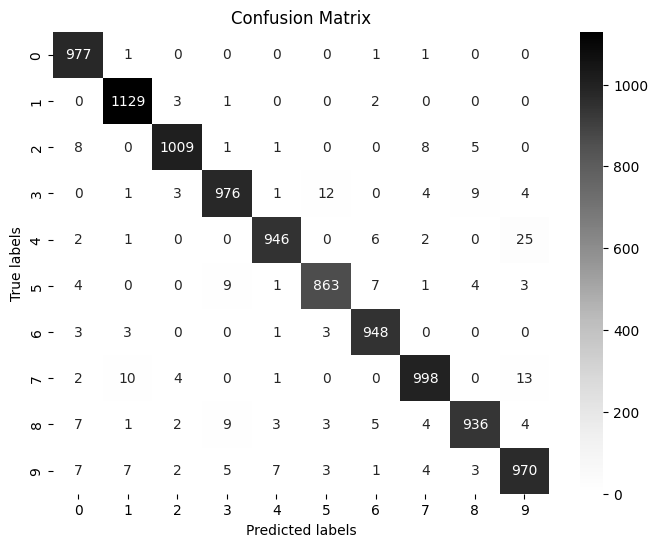

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
errors = np.where(pred != y_test)

In [29]:
y4 = np.where((y_test == "4") & (pred != y_test) )
y7 = np.where((y_test == "7") & (pred != y_test))
y3 = np.where((y_test == "3") & (pred != y_test))

<function matplotlib.pyplot.show(close=None, block=None)>

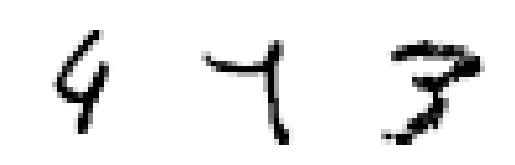

In [38]:
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(X_test[y4][0].reshape(28,28), cmap="Greys")
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(X_test[y7][0].reshape(28,28), cmap="Greys")
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(X_test[y3][0].reshape(28,28), cmap="Greys")
plt.show



# 5. Аугментации

In [4]:
import scipy.ndimage
import cv2

Повороты и сдвиги

[0 0 0 ... 0 0 0]


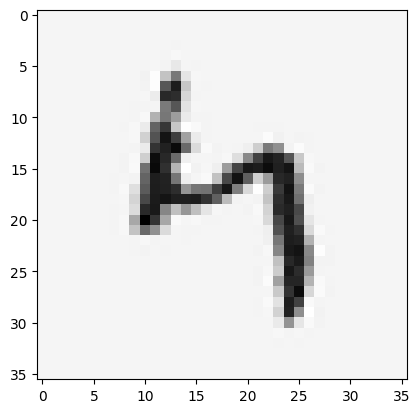

In [92]:
plt.imshow(scipy.ndimage.rotate(X_train[0].reshape(28,28),70), cmap="Greys")
print(scipy.ndimage.rotate(X_train[0].reshape(28,28),70).flatten())
plt.show()

In [97]:
rotations = range(-15,16,5)
folds = kfold(60000,3)
knn = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
scores= []
for train,test in folds:
    acc = []
    for r in rotations:
        augmentations = np.apply_along_axis(lambda x: scipy.ndimage.rotate(x.reshape(28,28),r,reshape=False).flatten(), 1, X_train[train])
        augmentations = np.concatenate((augmentations,X_train[train]),axis=0)
        aug_labels = np.concatenate((y_train[train],y_train[train]),axis=0)
        knn.fit(augmentations,aug_labels)
        acc.append(accuracy(y_train[test],knn.predict(X_train[test])))
        print(r,end="")
    scores.append(acc)
    print(acc)
    

-15-10-5051015[0.9764, 0.9774, 0.97605, 0.9733, 0.9767, 0.97735, 0.97655]
-15-10-5051015[0.9731, 0.9744, 0.97335, 0.9708, 0.9743, 0.9755, 0.97565]
-15-10-5051015[0.9729, 0.9748, 0.97395, 0.97045, 0.97475, 0.976, 0.9753]


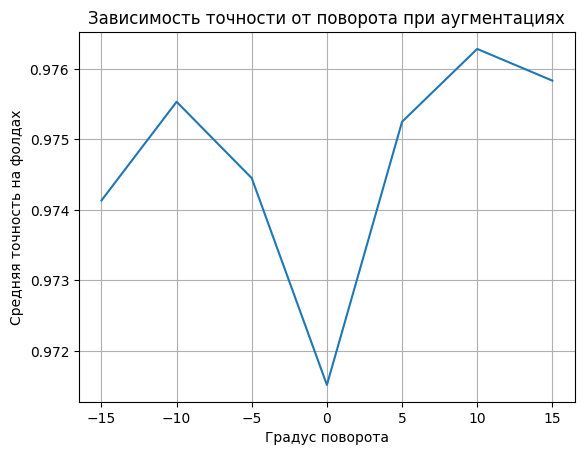

In [104]:
means = np.mean(scores,axis=0)
plt.plot(rotations,means)
plt.xlabel("Градус поворота")
plt.grid()
plt.ylabel("Средняя точность на фолдах")
plt.title("Зависимость точности от поворота при аугментациях")
plt.show()

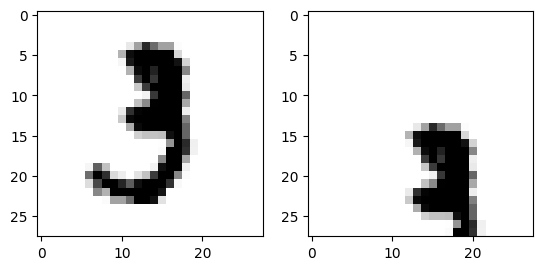

In [97]:
image = scipy.ndimage.shift(X_train[10].reshape(28,28), [10,2])
plt.subplot(1,2,1)
plt.imshow(X_train[10].reshape(28,28), cmap="Greys")

plt.subplot(1,2,2)
plt.imshow(image, cmap="Greys")
plt.show()

In [81]:
shifts = range(-3,4)
folds = kfold(60000,3)
knn = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
scores= []
for train,test in folds:
    acc = []
    for s in shifts:
        for s2 in shifts:
            augmentations = np.apply_along_axis(lambda x: scipy.ndimage.shift(x.reshape(28,28),[s,s2]).flatten(), 1, X_train[train])
            augmentations = np.concatenate((augmentations,X_train[train]),axis=0)
            aug_labels = np.concatenate((y_train[train],y_train[train]),axis=0)
            knn.fit(augmentations,aug_labels)
            acc.append(accuracy(y_train[test],knn.predict(X_train[test])))
            print(s,end="")
    scores.append(acc)
    print(acc)

-3-3-3-3-3-3-3-2-2-2-2-2-2-2-1-1-1-1-1-1-10000000111111122222223333333[0.9754, 0.9755, 0.9753, 0.97545, 0.9754, 0.97565, 0.97545, 0.9754, 0.9753, 0.97495, 0.97595, 0.97545, 0.97585, 0.97565, 0.9755, 0.9752, 0.97525, 0.9768, 0.9769, 0.9756, 0.97565, 0.97555, 0.97615, 0.9764, 0.9733, 0.9778, 0.97695, 0.97575, 0.97555, 0.9759, 0.9758, 0.9768, 0.9769, 0.9766, 0.97575, 0.9755, 0.976, 0.97595, 0.97675, 0.97675, 0.9761, 0.97545, 0.97555, 0.97555, 0.97615, 0.97585, 0.9758, 0.9756, 0.9756]
-3-3-3-3-3-3-3-2-2-2-2-2-2-2-1-1-1-1-1-1-10000000111111122222223333333[0.9731, 0.973, 0.973, 0.9733, 0.9734, 0.9731, 0.9732, 0.97315, 0.9731, 0.9726, 0.97395, 0.9739, 0.9734, 0.9731, 0.973, 0.97315, 0.97365, 0.9739, 0.97505, 0.97375, 0.9733, 0.9732, 0.97355, 0.9741, 0.9708, 0.9762, 0.97415, 0.9733, 0.97345, 0.97375, 0.97395, 0.97575, 0.97555, 0.97405, 0.9736, 0.9735, 0.97395, 0.97435, 0.97435, 0.9742, 0.97365, 0.97335, 0.9733, 0.97365, 0.97415, 0.9738, 0.9737, 0.9735, 0.9734]
-3-3-3-3-3-3-3-2-2-2-2-2-2-2-1-1-

In [88]:
means = np.array(scores).reshape(3,7,7)

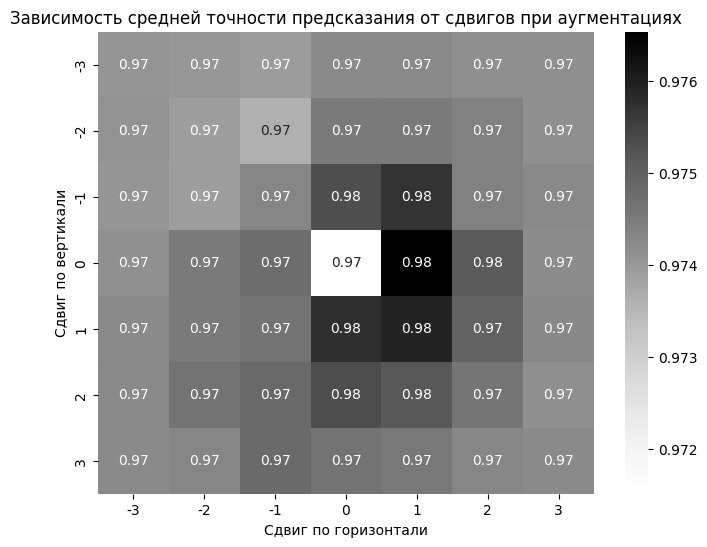

In [103]:
mean = np.mean(means,axis=0)
plt.figure(figsize=(8,6))
sns.heatmap(mean, annot=True,  cmap='Greys', xticklabels=range(-3,4), yticklabels=range(-3,4))
plt.xlabel("Сдвиг по горизонтали")
plt.ylabel("Сдвиг по вертикали")
plt.title("Зависимость средней точности предсказания от сдвигов при аугментациях")
plt.show()

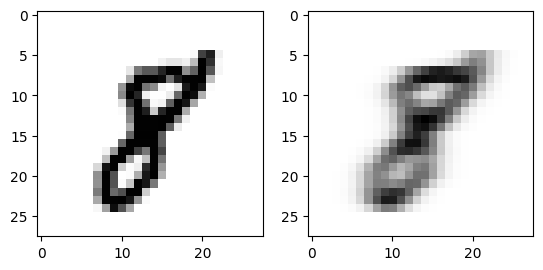

In [53]:
image = X_train[17].reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(image, cmap="Greys")

plt.subplot(1,2,2)
blur = scipy.ndimage.gaussian_filter1d(X_train[17], 1.5)
plt.imshow(blur.reshape(28,28), cmap="Greys")
plt.show()

In [25]:
sigmas = [0.5,1,1.5]
folds = kfold(60000,3)
knn = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=100)
scores= []
for train,test in folds:
    acc = []
    for s in sigmas:
        augmentations = scipy.ndimage.gaussian_filter1d(X_train[train],s,radius=5)
        augmentations = np.concatenate((augmentations,X_train[train]),axis=0)
        aug_labels = np.concatenate((y_train[train],y_train[train]),axis=0)
        knn.fit(augmentations,aug_labels)
        acc.append(accuracy(y_train[test],knn.predict(X_train[test])))
        print(s,end=" ")
    scores.append(acc)
    print(acc)

0.5 
1 
1.5 
[0.97415, 0.976, 0.9758]
0.5 
1 
1.5 
[0.9718, 0.97385, 0.97315]
0.5 
1 
1.5 
[0.97125, 0.9741, 0.97415]


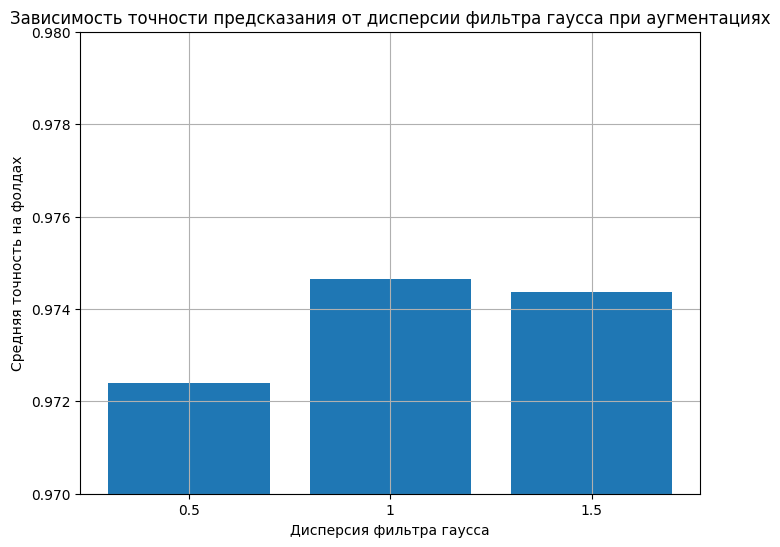

In [60]:
sigmas = ["0.5","1", "1.5"]
means = np.mean(scores,axis=0)
plt.figure(figsize=(8,6))
plt.bar(sigmas,means)
plt.ylim(0.97, 0.98)
plt.xlabel("Дисперсия фильтра гаусса")
plt.grid()
plt.ylabel("Средняя точность на фолдах")
plt.title("Зависимость точности предсказания от дисперсии фильтра гаусса при аугментациях")
plt.show()

(784, 1)


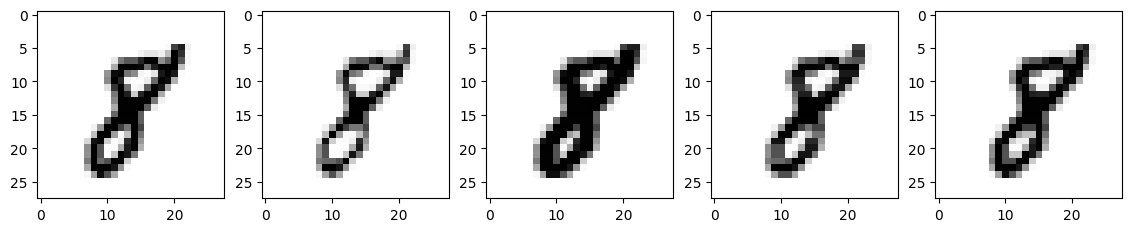

In [42]:
image = X_train[17].reshape(28,28)
plt.figure(figsize=(14,6))
plt.subplot(1,5,1)
plt.imshow(image, cmap="Greys")


plt.subplot(1,5,2)
er = cv2.erode(X_train[17].astype('uint8'),(2,2))
print(er.shape)
plt.imshow(er.reshape(28,28), cmap="Greys")

plt.subplot(1,5,3)
di = cv2.dilate(X_train[17].astype('uint8'),(2,2))
plt.imshow(di.reshape(28,28), cmap="Greys")

plt.subplot(1,5,4)
cl = cv2.morphologyEx(X_train[17].astype('uint8'),cv2.MORPH_OPEN,(2,2))
plt.imshow(cl.reshape(28,28), cmap="Greys")

plt.subplot(1,5,5)
cl = cv2.morphologyEx(X_train[17].astype('uint8'),cv2.MORPH_CLOSE,(2,2))
plt.imshow(cl.reshape(28,28), cmap="Greys")

plt.show()

In [15]:
aug = np.concatenate((
    X_train,
    scipy.ndimage.rotate(X_train,10,reshape=False),
    scipy.ndimage.shift(X_train, [0,1]),
    scipy.ndimage.gaussian_filter1d(X_train,1,radius=5),
    np.apply_along_axis(lambda x: cv2.erode(x.astype('uint8'),(2,2)).reshape(784),1,X_train),
    np.apply_along_axis(lambda x: cv2.dilate(x.astype('uint8'),(2,2)).reshape(784),1,X_train),
    # np.apply_along_axis(lambda x: cv2.morphologyEx(x.astype('uint8'),cv2.MORPH_CLOSE,(2,2)).reshape(784),1,X_train),
    # np.apply_along_axis(lambda x: cv2.morphologyEx(x.astype('uint8'),cv2.MORPH_OPEN,(2,2)).reshape(784),1,X_train)
),axis=0)

In [8]:
del X_train

In [ ]:
aug.shape

In [16]:
aug_y = np.tile(y_train, (1,6)).reshape(aug.shape[0],1)

In [11]:
aug_y.shape

(180000, 1)

In [17]:
knn = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=1000)
knn.fit(aug, aug_y)
pred = knn.predict(X_test)
print(accuracy(y_test,pred))

0.9776


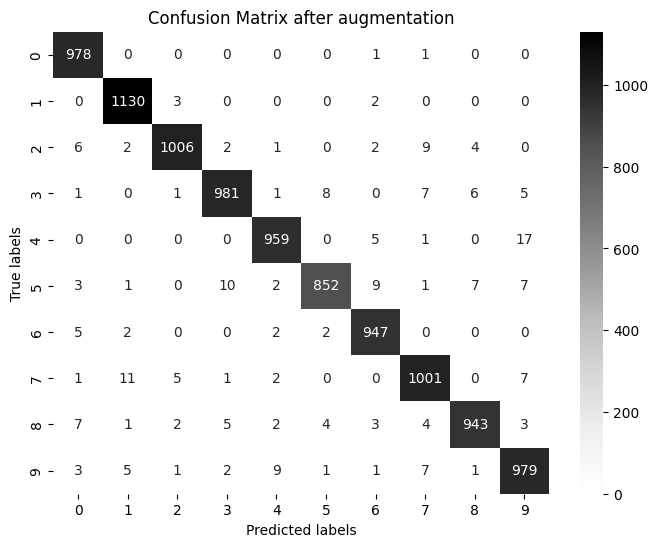

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after augmentation')
plt.show()

# 6. Аугментации тестовой выборки

In [43]:
r_test = scipy.ndimage.rotate(X_test,-5,reshape=False)
s_test = scipy.ndimage.shift(X_test, [0,-1])
g_test = scipy.ndimage.gaussian_filter1d(X_test,1,radius=5)
e_test = np.apply_along_axis(lambda x: cv2.erode(x.astype('uint8'),(2,2)).reshape(784),1,X_test)
d_test = np.apply_along_axis(lambda x: cv2.dilate(x.astype('uint8'),(2,2)).reshape(784),1,X_test)
c_test = np.apply_along_axis(lambda x: cv2.morphologyEx(x.astype('uint8'),cv2.MORPH_CLOSE,(2,2)).reshape(784),1,X_test)
o_test =  np.apply_along_axis(lambda x: cv2.morphologyEx(x.astype('uint8'),cv2.MORPH_OPEN,(2,2)).reshape(784),1,X_test)

In [44]:
knn = KNNClassifier(k=4, strategy="brute", metric="cosine", weights=True, test_block_size=1000)
knn.fit(X_train, y_train)
predictions = np.vstack((knn.predict(X_test),
                              knn.predict(r_test),
                              knn.predict(s_test),
                              knn.predict(g_test),
                              knn.predict(e_test),
                              knn.predict(d_test),
                              knn.predict(c_test),
                              knn.predict(o_test)
                             ))

In [85]:
predictions = predictions.transpose()

In [45]:
fin_pred = np.argmax(np.apply_along_axis(lambda p: np.bincount(p,minlength=10),0,predictions.astype("int")),axis=0).astype("str")

In [46]:
print(accuracy(y_test,fin_pred))

0.9721


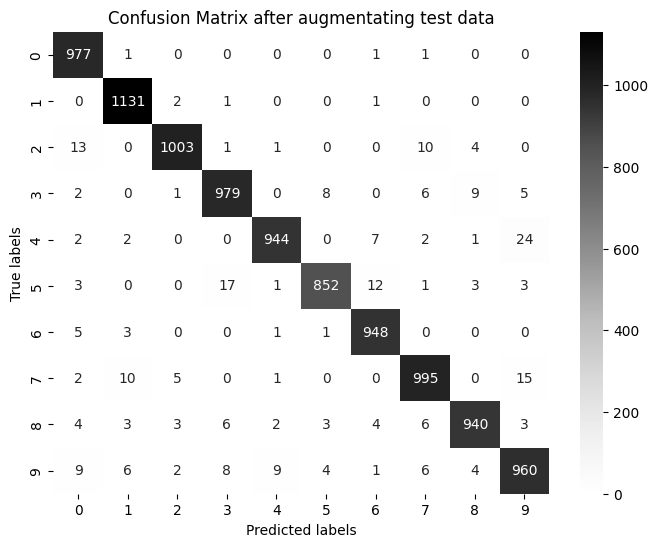

In [110]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, fin_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after augmentating test data')
plt.show()